In this notebook, we are going to use Latent Dirichlet Allocation (LDA) for topic modeling to retrieve topics from 20K different Wikipedia abstracts in an unsuperivsed way.  Click here [here](https://raw.githubusercontent.com/vinid/data/master/dbpedia_sample_abstract_20k_unprep.txt) to download the data.

In [1]:
import sys
import re
import nltk
import string
import pandas as pd
import numpy as np
import gensim
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import warnings
import random
from time import time

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

%matplotlib inline

In [2]:
print(sys.version)
print('numpy:',np.__version__)
print('pandas:',pd.__version__)
print('nltk:',nltk.__version__)
print('gensim:',gensim.__version__)

3.8.8 (default, Feb 24 2021, 13:46:16) 
[Clang 10.0.0 ]
numpy: 1.19.2
pandas: 1.2.3
nltk: 3.5
gensim: 3.8.3


In [3]:
with open("./dbpedia_sample_abstract_20k_unprep.txt", 'r') as fr:
    text = [line.strip() for line in fr.readlines()]

In [4]:
random.shuffle(text)
print('total number of Wikipedia abstracts:',len(text))

total number of Wikipedia abstracts: 20000


In [5]:
# print the first sentence
pprint(text[0])

('Thompson Rivers University, Open Learning (TRU-OL) is a Canadian distance '
 'education provider, operating as the Open Learning Division of Thompson '
 'Rivers University (TRU) in Kamloops, British Columbia. The Open Learning '
 "Division, which is situated in the BC Centre for Open Learning on TRU's "
 'Kamloops campus, offers courses and programs through')


### 1. Data cleaning & preprocessing

In [6]:
def cleanPunc(sentence):
    '''Clean a sentence of any punctuation or special characters'''
    cleaned = re.sub(r'[?|!|\'|"|#|”|’]',r'',sentence)
    cleaned = re.sub(r'[.|,|(|)|\|/|-|–]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n","")
    cleaned = re.sub('\s+',' ',cleaned) #replace multiple spaces with a single one
    return cleaned

In [7]:
def preprocess(sentence):
    '''Preprocess text, get rid of special chars, convert to lower, remove stop words.'''
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub('\s+',' ',sentence)
    sentence = sentence.replace("\n","")
    sentence = sentence.lower()
    sentence = [word for word in sentence.split() if word not in stopwords and len(word) > 1]
    sentence = [lemmatizer.lemmatize(word) for word in sentence]
    return ' '.join(sentence)

In [8]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
stopwords = set(stopwords)

[nltk_data] Downloading package stopwords to /Users/isra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/isra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [10]:
cleaned_text = list(map(cleanPunc, text))
cleaned_text = list(map(preprocess, cleaned_text))

In [11]:
# print the first sentence again
print('A raw sentence:\n')
pprint(text[0])
print('\nThe same sentence after pre-processing:\n')
pprint(cleaned_text[0])

A raw sentence:

('Thompson Rivers University, Open Learning (TRU-OL) is a Canadian distance '
 'education provider, operating as the Open Learning Division of Thompson '
 'Rivers University (TRU) in Kamloops, British Columbia. The Open Learning '
 "Division, which is situated in the BC Centre for Open Learning on TRU's "
 'Kamloops campus, offers courses and programs through')

The same sentence after pre-processing:

('thompson river university open learning tru ol canadian distance education '
 'provider operating open learning division thompson river university tru '
 'kamloops british columbia open learning division situated bc centre open '
 'learning trus kamloops campus offer course program')


In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/isra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### Split sentences into tokens (words)

In [13]:
from nltk import word_tokenize
tokens = list(map(word_tokenize, cleaned_text))

In [14]:
df=pd.DataFrame()
df['abstract']=text
df['tokens']=tokens
df.head()

abstract  \
0                             Thompson Rivers University, Open Learning (TRU-OL) is a Canadian distance education provider, operating as the Open Learning Division of Thompson Rivers University (TRU) in Kamloops, British Columbia. The Open Learning Division, which is situated in the BC Centre for Open Learning on TRU's Kamloops campus, offers courses and programs through   
1                                                                                   The 15th Operations Group (15 OG) is the flying component of the 15th Wing, assigned to the United States Air Force Thirteenth Air Force. The group is stationed at Hickam Air Force Base, Hawaii. The 15 OG is responsible for managing operational matters at Hickam Air Force Base and Bellows   
2                                                              Sharon Anglin Treat (born January 30, 1956) is an American politician and attorney from Maine. A Democrat, Treat has served in the Maine Legislature since 1990. Treat has represented Hallowell, Maine in Kennebec County in the Maine House of Representatives since 2006. She is unable to seek re-election in 2014   
3  P2i is a nanotechnology development company that works with manufacturers to produce liquid repellent nano-coating protection to products for the electronics, lifestyle, life sciences, filtration and Energy, and military and institutional sectors. The company was established in 2004 to commercialize technologies developed by the UK MoD’s Defense Science and Technology   
4                                                                                          The 2009 World Cup Taekwondo Team Championships is the 2nd edition of the World Cup Taekwondo Team Championships, and was held at Baku Sports Hall in Baku, Azerbaijan from June 11 to June 14, 2009. The participating male and female teams are divided into six groups each and the top   

                                                                                                                                                                                                                                                                                                                      tokens  
0        [thompson, river, university, open, learning, tru, ol, canadian, distance, education, provider, operating, open, learning, division, thompson, river, university, tru, kamloops, british, columbia, open, learning, division, situated, bc, centre, open, learning, trus, kamloops, campus, offer, course, program]  
1                                                                 [th, operation, group, og, flying, component, th, wing, assigned, united, state, air, force, thirteenth, air, force, group, stationed, hickam, air, force, base, hawaii, og, responsible, managing, operational, matter, hickam, air, force, base, bellow]  
2                                                                     [sharon, anglin, treat, born, january, american, politician, attorney, maine, democrat, treat, served, maine, legislature, since, treat, represented, hallowell, maine, kennebec, county, maine, house, representative, since, unable, seek, election]  
3  [nanotechnology, development, company, work, manufacturer, produce, liquid, repellent, nano, coating, protection, product, electronics, lifestyle, life, science, filtration, energy, military, institutional, sector, company, established, commercialize, technology, developed, uk, mod, defense, science, technology]  
4                                                                                                    [world, cup, taekwondo, team, championship, nd, edition, world, cup, taekwondo, team, championship, held, baku, sport, hall, baku, azerbaijan, june, june, participating, male, female, team, divided, six, group, top]

In [15]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(df["tokens"])
dictionary

In [16]:
len(dictionary)

67811

#### Filter out tokens that appear in less than `no_below` abstracts (absolute number) or more than `no_above` fraction of total abstracts

In [17]:
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [18]:
len(dictionary)

3506

####  Convert `document` into the bag-of-words (BoW) format = list of `(token_id, token_count)` tuples.

In [19]:
corpus = [dictionary.doc2bow(abstract) for abstract in df["tokens"]]

### 2. Apply LDA model

In [20]:
from gensim import models

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=48, random_state=43,
                chunksize=200, passes=10,update_every=5)



In [21]:
#pprint(lda_model.print_topics(num_words=10))
for i, t in enumerate(range(lda_model.num_topics)): 
    topic_dict = dict(lda_model.show_topic(t, 10)) # topic - top 10 words dictionary
    print(str(t+1),':',list(topic_dict.keys()))

1 : ['american', 'award', 'best', 'director', 'record', 'known', 'born', 'radio', 'singer', 'actor']
2 : ['game', 'produced', 'five', 'style', 'video', 'developed', 'take', 'first', 'leading', 'chicago']
3 : ['film', 'directed', 'written', 'role', 'based', 'drama', 'actress', 'action', 'lead', 'similar']
4 : ['major', 'baseball', 'red', 'product', 'two', 'real', 'left', 'enzyme', 'food', 'chemical']
5 : ['new', 'york', 'city', 'representative', 'jersey', 'grade', 'wisconsin', 'american', 'republican', 'representing']
6 : ['river', 'chinese', 'long', 'indian', 'china', 'star', 'italy', 'traditional', 'creek', 'department']
7 : ['william', 'roman', 'title', 'robert', 'catholic', 'figure', 'senior', 'may', 'mary', 'lost']
8 : ['union', 'people', 'zealand', 'age', 'order', 'military', 'eight', 'would', 'soviet', 'way']
9 : ['st', 'road', 'route', 'end', 'hall', 'neighborhood', 'city', 'part', 'reserve', 'located']
10 : ['south', 'india', 'australia', 'forest', 'small', 'africa', 'open', 'b

### 3. Topic visualization

Plot word cloud for each topic

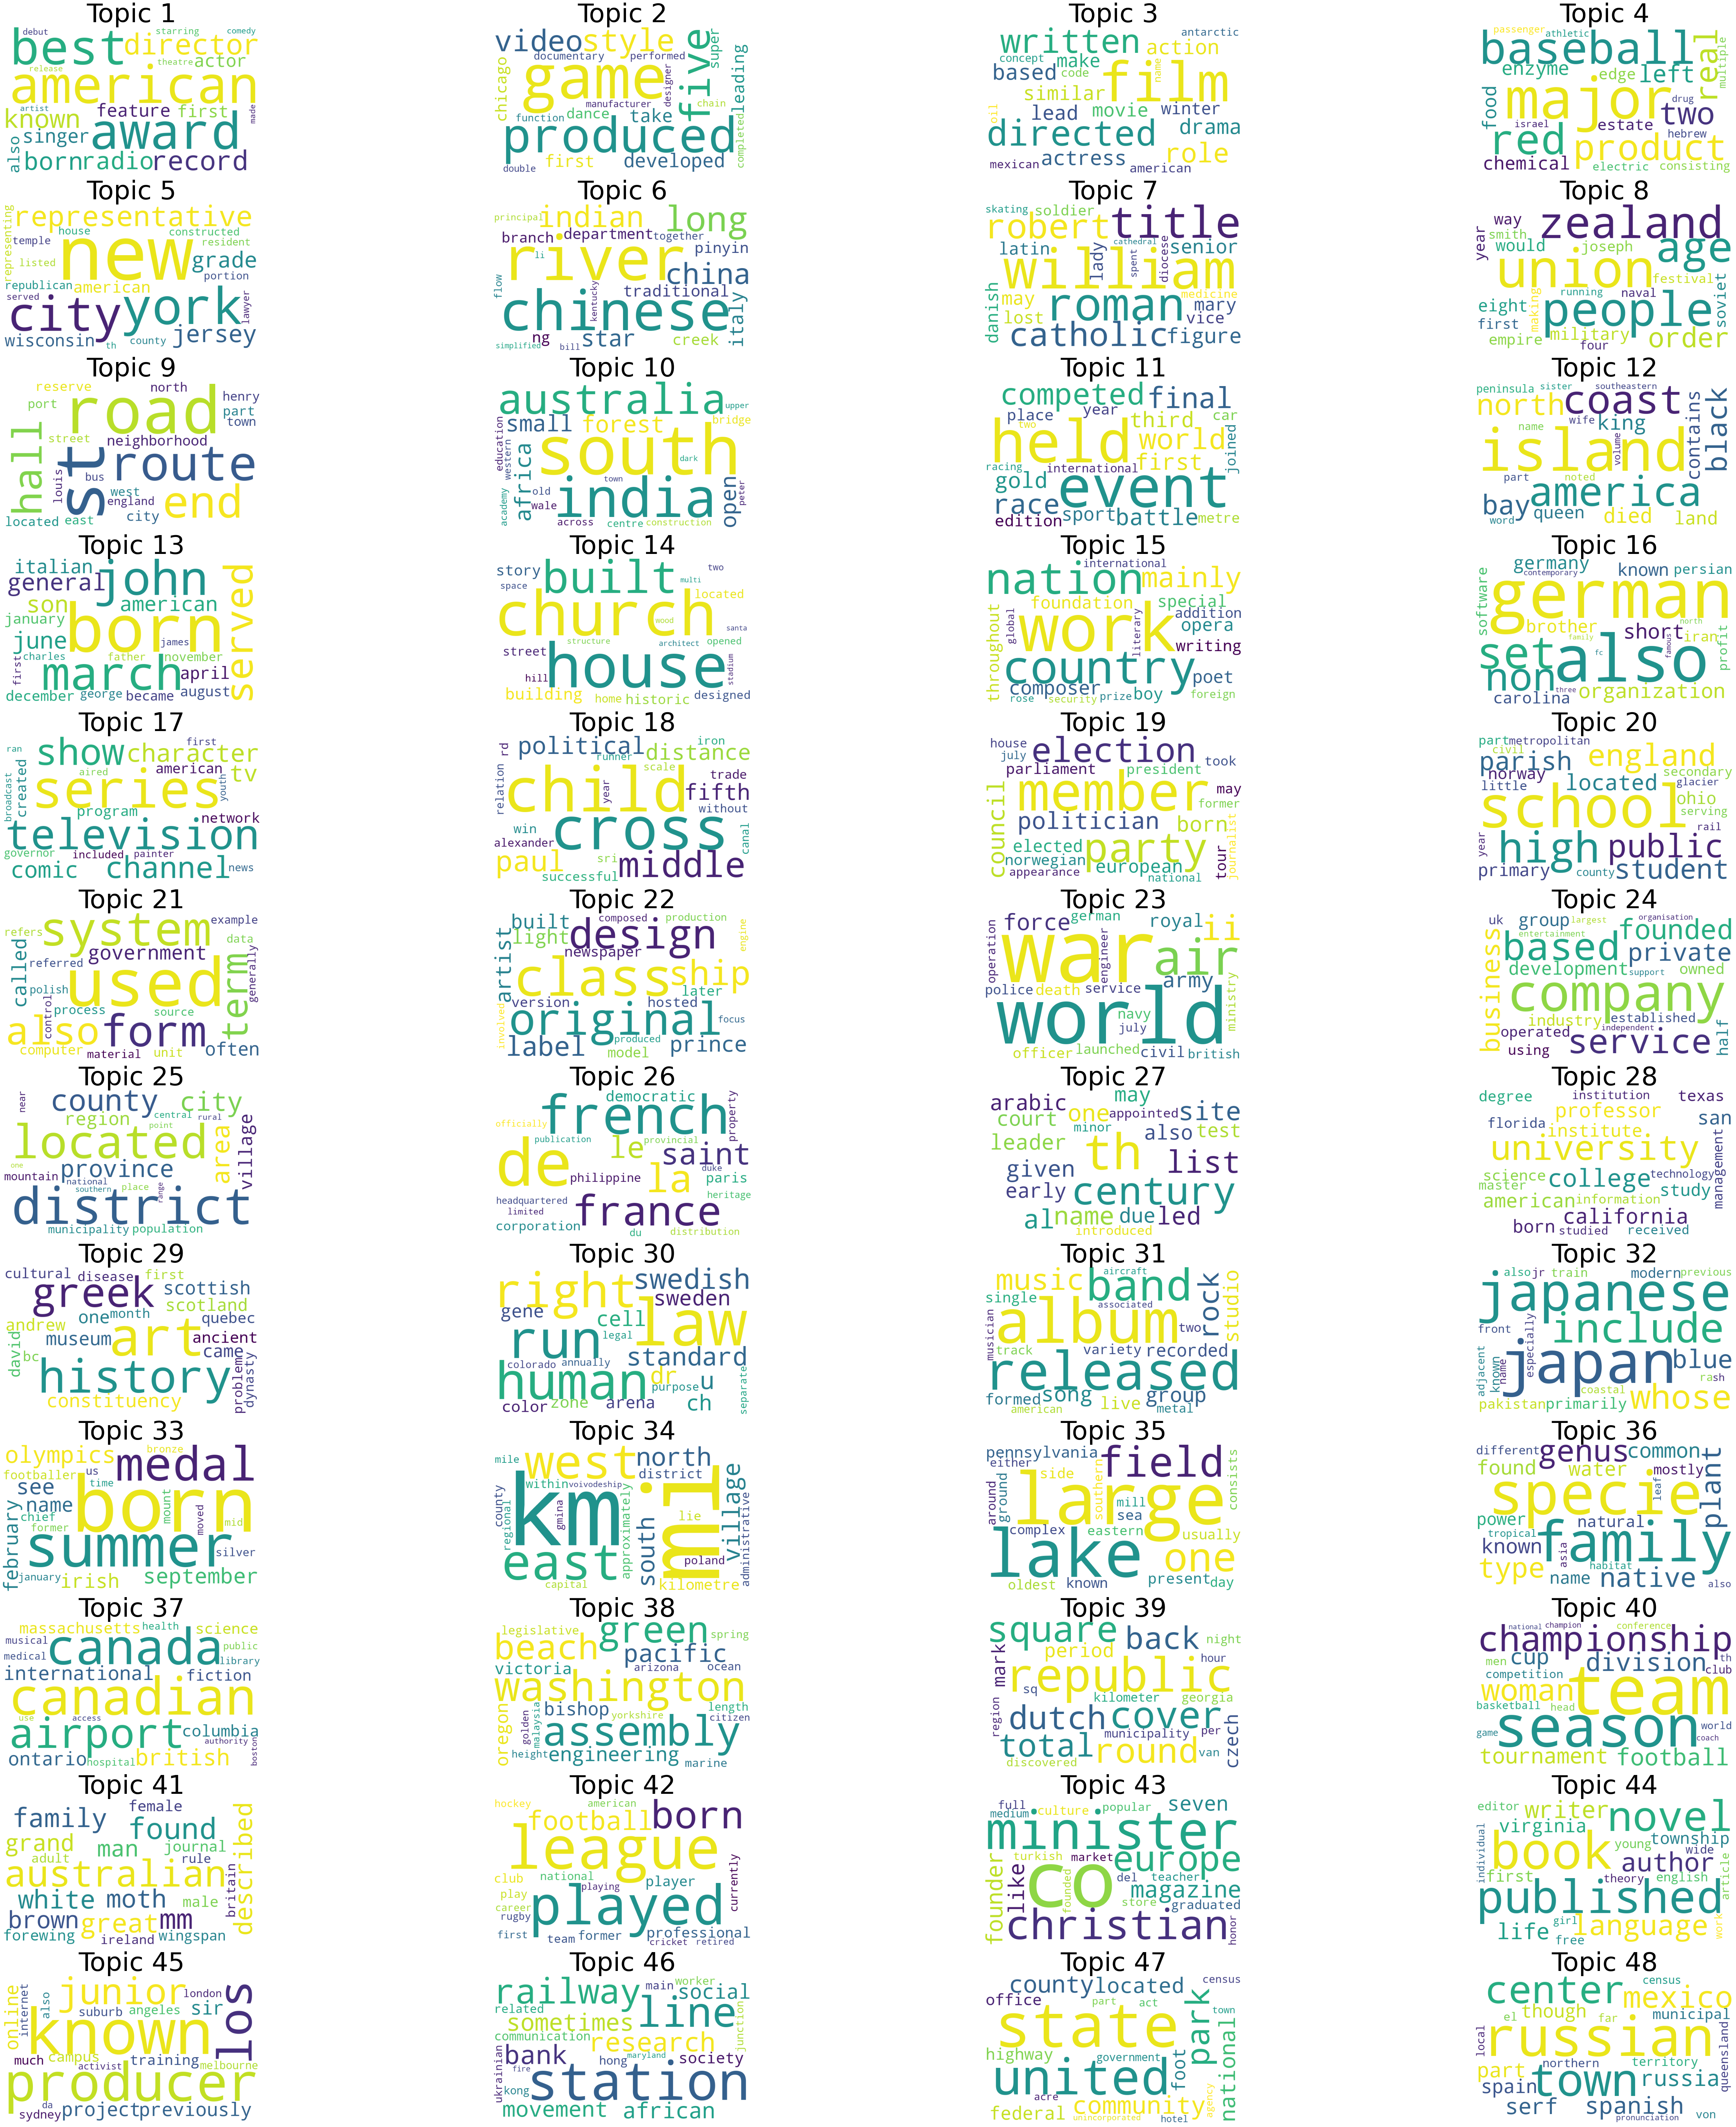

In [22]:
from wordcloud import WordCloud

fig, axs = plt.subplots(ncols=4, nrows=int(lda_model.num_topics/4), figsize=(80,80))
axs = axs.flatten()

for i, t in enumerate(range(lda_model.num_topics)): 
    topic_dict = dict(lda_model.show_topic(t, 20))
    im = WordCloud(
        width=800, height=460,
        #max_words = 20,
        background_color='white',
        random_state=0
    ).generate_from_frequencies(topic_dict)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t+1),fontsize=70)

plt.tight_layout()
plt.show()

### <font color='darkblue'>You can see some word which are relevant to the same topic already grouped together, for example:</font> 

1. topic 3 seems to be about films
2. topic 23 is about WW2
3. topic 28 seems to be about eduation and schools
4. topic 34 more about geograpich locations.

Please note that if you re-run the notebook with the same parameters the topic IDs will differ but the same words will cluster to form the same topic.

To improve the results one can also further improve the data cleaning step and one can further tune the LDA model by trying different parameters for chunksize, passes, update_every, check the help manual for more details.

